# Predicting non-response to ketamine for depression: a symptom-level analysis of real-world data

## Imported libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local helpers
from lib.helpers import *

# Python core
import os
import math
import warnings

# Scipy family
import numpy as np
import pandas as pd
from datetime import date
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RepeatedKFold

# Other
import pingouin as pg
from itertools import combinations
from statsmodels.stats.anova import AnovaRM

/Users/ericmiller/anaconda3/envs/science/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Establish global variables

In [2]:
panels_output_directory = './panels/'
outdir = os.path.expanduser(panels_output_directory)

preprocess_output_directory = './preprocess/'
preprocess_outdir = os.path.expanduser(preprocess_output_directory)

plt.rcParams['pdf.fonttype'] = 42  # embed fonts so we can edit in Illustrator
resolution = 1000  # DPI
warnings.filterwarnings('ignore')

## Load raw data and confirm valid

In [3]:
# Load data
all_data = pd.read_csv('./data.csv')
all_data['sex'] = [0 if s=='M' else 1 for s in all_data['sex'].values]
unique_patient_ids = np.unique(all_data['ID'].values)

# Grab the essential columns of data for subsequent analysis
all_phq_item_cols = ['phqitem' + str(i) for i in np.arange(1, 10)]
essential_cols_phq = ['ID', 'age', 'sex', 'route', 'sessionNumber', 'sessionDay', 'phqtotal'] + all_phq_item_cols
d_phq = all_data[essential_cols_phq]
d_phq = d_phq[~np.isnan(d_phq).any(axis=1)]
d_phq = d_phq.sort_values(by='ID')

# Ensure that patients have valid baseline and longitudinal data
valid_phq_subjects = []
for patient_idx, patient_id in enumerate(unique_patient_ids):
    d_patient = d_phq[d_phq['ID']==patient_id]
    if d_patient.shape[0] == 0:
        print("PHQ-9: no data at all for patient %d" % patient_id)
    elif np.min(d_patient['sessionNumber']) != 1:
        print("PHQ-9: no baseline data for patient %d" % patient_id)
    elif np.max(d_patient['sessionNumber']) < 2:
        print("PHQ-9: less than 2 repeats for patient %d" % patient_id)
    else:
        valid_phq_subjects.append(patient_id) 
d_phq = d_phq[d_phq['ID'].isin(valid_phq_subjects)].sort_values(by='ID')

print("%d of %d subjects have valid data" % (len(valid_phq_subjects), len(unique_patient_ids)))


120 of 120 subjects have valid data


In [4]:
# i = 0
# mdd = 0
# bl = []
# data = all_data[all_data['sessionNumber']==1]
# for pid in unique_patient_ids:
#     i += 1
#     d = data[data['ID']==pid]
#     diag = d['diagnosis'].values[0].lower()
#     if 'major depression' in diag or 'mdd' in diag or 'major depressive' in diag or 'depression' in diag:
#         mdd += 1
#     else:
#         print(diag)
#         bl.append(d['phqtotal'].values[0])
#         print('\n')
# print(mdd / i)
# print(np.mean(bl))
# print(bl)

## Basic patient demographics and absolute dose ranges

In [5]:
demo = pd.DataFrame(columns=['ID', 'age', 'sex', 'route', 'dose_min', 'dose_max'])
ix = 0
for patient_id in unique_patient_ids:
    d_patient = all_data[all_data['ID']==patient_id]
    sex = d_patient['sex'].values[0]
    route = np.unique(d_patient['route'].values)[0]
    age = d_patient['age'].values[0]
    dose_min = d_patient['dose'].min()
    dose_max = d_patient['dose'].max()
    demo.loc[ix] = [patient_id, age, sex, route, dose_min, dose_max]
    ix += 1
    
# Demographics
num_female = demo[demo['sex']==1].shape[0]
num_male = demo[demo['sex']==0].shape[0]
num_IN = demo[demo['route']==1].shape[0]
num_IV = demo[demo['route']==2].shape[0]
num_IM = demo[demo['route']==3].shape[0]
ages = demo['age'].values
# Doses min
dose_min_IN = demo[demo['route']==1]['dose_min'].mean()
dose_min_IV = demo[demo['route']==2]['dose_min'].mean()
dose_min_IM = demo[demo['route']==3]['dose_min'].mean()
# Doses max
dose_max_IN = demo[demo['route']==1]['dose_max'].mean()
dose_max_IV = demo[demo['route']==2]['dose_max'].mean()
dose_max_IM = demo[demo['route']==3]['dose_max'].mean()

print("Total N = %d" % len(ages))
print("Sexes: %d male, %d female" % (num_male, num_female))
print("Ages: range %d to %d (Mean %f, STD %f)." % (np.min(ages), np.max(ages), np.mean(ages), np.std(ages)))
print("Route of admin: %d IN, %d IV, %d IM" % (num_IN, num_IV, num_IM))
print("Avg min dose: %f (IN), %f (IV), %f (IM)" % (dose_min_IN, dose_min_IV, dose_min_IM))
print("Avg max dose: %f (IN), %f (IV), %f (IM)" % (dose_max_IN, dose_max_IV, dose_max_IM)) 

Total N = 120
Sexes: 85 male, 35 female
Ages: range 26 to 75 (Mean 45.216667, STD 11.554352).
Route of admin: 99 IN, 20 IV, 1 IM
Avg min dose: 56.626263 (IN), 51.222222 (IV), 35.000000 (IM)
Avg max dose: 83.717172 (IN), 88.611111 (IV), 70.000000 (IM)


## Average PHQ-9 sum scores across induction sessions

82 of 120 subjects have complete sum score data
                 Source         W  ddof1           Q         p-unc
Friedman  sessionNumber  0.180335      7  103.512433  2.027510e-19


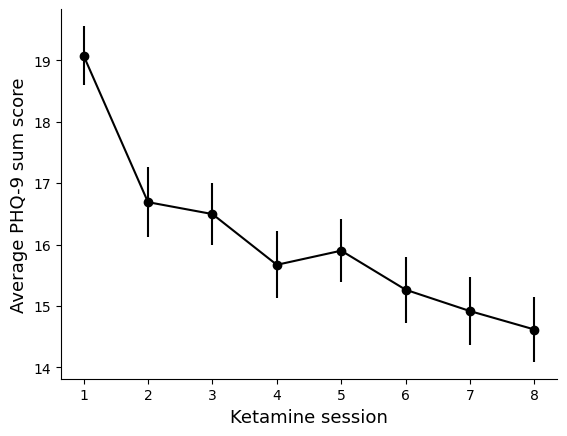

In [6]:
# Plot average sum scores across session
mus = []
sems = []
for sessionIdx in np.arange(1, 9):
    d_session = d_phq[d_phq['sessionNumber']==sessionIdx]
    mus.append(d_session['phqtotal'].mean())
    sems.append(d_session['phqtotal'].sem())
plt.figure()
ax = plt.subplot(111)
ax.errorbar(np.arange(1, 9), mus, yerr=sems, color='k', marker='o', linestyle='-')
plt.xlabel('Ketamine session', fontsize=13)
plt.ylabel('Average PHQ-9 sum score', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'avgPHQ9sumScores.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

# Repeated measures ANOVA (only patients with complete data)
d_full = pd.DataFrame(columns=['ID', 'sessionNumber', 'phqtotal'])
ix = 0
for sid in unique_patient_ids:
    d_subject = d_phq[d_phq['ID']==sid]
    sessions = np.sort(d_subject['sessionNumber'].values)
    induction_sessions = [s for s in sessions if s <= 8]
    if len(induction_sessions) == 8:  # subjects with exactly 8 repeats of PHQ-9 total score
        for sessionNum in np.arange(1, 9):
            sumscore = d_subject[d_subject['sessionNumber']==sessionNum]['phqtotal'].values[0]
            d_full.loc[ix] = [sid, sessionNum, sumscore]
            ix += 1
sid_full = d_full['ID'].unique()
print("%d of %d subjects have complete sum score data" % (len(sid_full), len(unique_patient_ids)))
friedmanRes = pg.friedman(data=d_full, dv="phqtotal", within="sessionNumber", subject="ID")
print(friedmanRes)

# Check for normality of sum scores at each session
# for sessionNum in np.arange(1, 9):
#     sessionSumScores = d_full[d_full['sessionNumber']==sessionNum]['phqtotal'].values
#     plt.figure()
#     plt.title(str(sessionNum))
#     plt.hist(sessionSumScores)
#     print("Session %d" % sessionNum)
#     print(stats.shapiro(sessionSumScores))

## Average PHQ-9 item scores across induction sessions


ITEM #1: 82 of 120 subjects have complete data
                 Source         W  ddof1          Q         p-unc
Friedman  sessionNumber  0.159264      7  91.417582  6.327327e-17

ITEM #2: 82 of 120 subjects have complete data
                 Source         W  ddof1          Q         p-unc
Friedman  sessionNumber  0.161682      7  92.805732  3.279377e-17

ITEM #3: 82 of 120 subjects have complete data
                 Source         W  ddof1         Q         p-unc
Friedman  sessionNumber  0.075437      7  43.30061  2.918152e-07

ITEM #4: 82 of 120 subjects have complete data
                 Source         W  ddof1          Q     p-unc
Friedman  sessionNumber  0.066227      7  38.014122  0.000003

ITEM #5: 82 of 120 subjects have complete data
                 Source         W  ddof1          Q     p-unc
Friedman  sessionNumber  0.065672      7  37.695946  0.000003

ITEM #6: 82 of 120 subjects have complete data
                 Source         W  ddof1          Q         p-unc
Frie

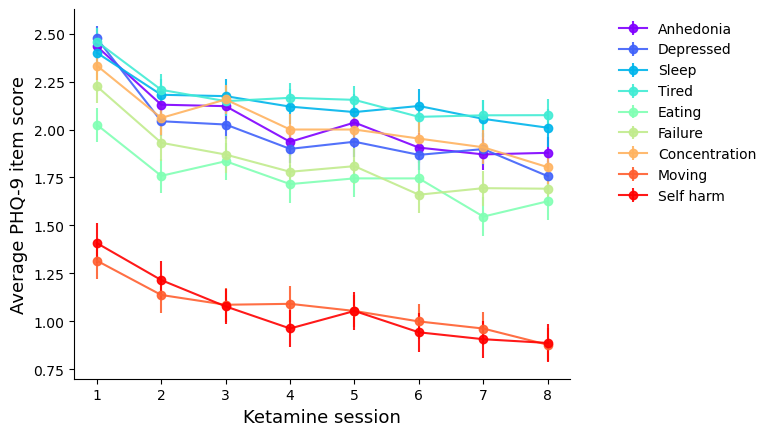

In [7]:
# Plot average PHQ-9 item scores across participants at the first 8 sessions
phq_items = ['Anhedonia', 'Depressed', 'Sleep', 'Tired', 'Eating', 'Failure', 'Concentration', 'Moving', 'Self harm']
plt.figure()
ax = plt.subplot(111)
ls = []
colors = plt.cm.rainbow(np.linspace(0,1,9))
all_slopes_phq = []
for item_idx in np.arange(1, 10):
    item_name = 'phqitem' + str(item_idx)
    mus = []
    sems = []
    for sessionIdx in np.arange(1, 9):
        d_session = d_phq[d_phq['sessionNumber']==sessionIdx]
        mus.append(d_session[item_name].mean())
        sems.append(d_session[item_name].sem())
    l = ax.errorbar(np.arange(1, 9), mus, yerr=sems, color=colors[item_idx-1], alpha=0.9, marker='o', 
                    linestyle='-', label=phq_items[item_idx-1])
    ls.append(l)
    slope, intercept, r, p, se = stats.linregress(np.arange(1, 9), mus)
    all_slopes_phq.append(slope)
plt.legend(frameon=False, bbox_to_anchor=(0.5, 0.5, 0.9, 0.5))
plt.xlabel('Ketamine session', fontsize=13)
plt.ylabel('Average PHQ-9 item score', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'avgPHQ9itemScores.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

# Test for significant change in item response across sessions
for item_num in np.arange(1, 9):
    item = 'phqitem' + str(item_num)
    d_full = pd.DataFrame(columns=['ID', 'sessionNumber', 'item_response'])
    ix = 0
    for sid in unique_patient_ids:
        d_subject = d_phq[d_phq['ID']==sid][[item, 'sessionNumber']]
        sessions = np.sort(d_subject['sessionNumber'].values)
        induction_sessions = [s for s in sessions if s <= 8]
        if len(induction_sessions) == 8:  # subjects with exactly 8 repeats of this item
            for sessionNum in np.arange(1, 9):
                item_score = d_subject[d_subject['sessionNumber']==sessionNum][item].values[0]
                d_full.loc[ix] = [sid, sessionNum, item_score]
                ix += 1
    sid_full = d_full['ID'].unique()
    print("\nITEM #%d: %d of %d subjects have complete data" % (item_num, len(sid_full), len(unique_patient_ids)))
    
    friedmanRes = pg.friedman(data=d_full, dv="item_response", within="sessionNumber", subject="ID")
    print(friedmanRes)

## Compare linear and exponential fits to item trajectories for individual patients
Note, if you want to see all of the fits for every item and every patient, change the show_all_fits variable to True.

AIC: 104 patients better with linear, 16 patients better with exponential
BIC: 105 patients better with linear, 15 patients better with exponential


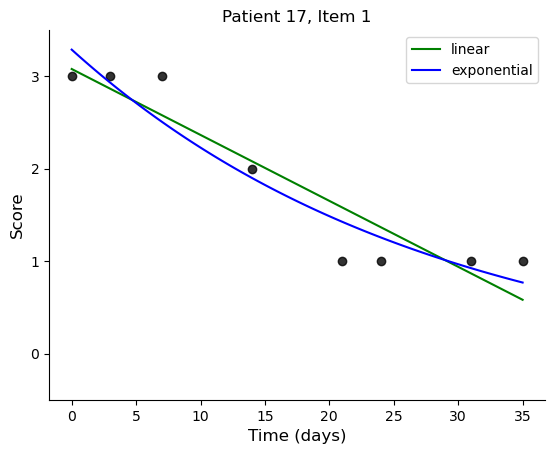

In [8]:
show_all_fits = False # Set to True to plot all of the item fits for every patietnt

# k = number of parameters in each model, including implicit parameter for error variance
k_exp = 4
k_lin = 3

df_slopes = pd.DataFrame(columns=['id', 'item', 'slope_exp', 'slope_lin', 'rss_exp', 'rss_lin'])
df_info = pd.DataFrame(columns=['id', 'item', 'aic_lin', 'bic_lin', 'aic_exp', 'bic_exp'])
df_idx = 0
for patient_idx, patient_id in enumerate(valid_phq_subjects):
    d_patient = d_phq[d_phq['ID']==patient_id]
    for item_number in np.arange(1, 10):
        xs, ys = get_indiv_item_curve(d_patient, item_number, questionnaire='phq')
        n = len(ys)
        
        # Fit linear model
        init_slope = (ys[-1] - ys[0]) / (xs[-1] - xs[0])
        init_intercept = ys[0]
        res = minimize(rss_linear, x0=[init_slope, init_intercept], args=(np.array(xs), np.array(ys)))
        slope, intercept = res.x
        rss_lin = res.fun
        
        # Fit exponential model       
        init_offset = ys[-1]
        res = minimize(rss_exponential, x0=[1, 1, init_offset], args=(np.array(xs), np.array(ys)))
        a, b, c = res.x 
        rss_exp = res.fun
        
        # Plot both models overlaid on data
        title = "Patient %d, Item %d" % (patient_id, item_number)
        if show_all_fits:
            plot_both_lin_exp(xs, ys, slope, intercept, a, b, c, title=title)
        if (patient_id == 17) and (item_number == 1):
            plot_both_lin_exp(xs, ys, slope, intercept, a, b, c, title=title)
            plt.savefig(fname=outdir+'egItemFitsPHQ9.pdf', format='pdf', dpi=resolution, bbox_inches="tight")
        
        # Compute AIC and BIC for the linear and exponential fits
        n = d_patient.shape[0]
        if rss_lin == 0:
            aic_lin = -np.inf
            bic_lin = -np.inf
        else:
            aic_lin = 2 * k_lin + n * np.log(rss_lin / n)
            bic_lin = np.log(n) * k_lin + n * np.log(rss_lin / n)
        if rss_exp == 0:
            aic_exp = -np.inf
            bic_exp = -np.inf
        else:
            aic_exp = 2 * k_exp + n * np.log(rss_exp / n)
            bic_exp = np.log(n) * k_exp + n * np.log(rss_exp / n)

        # Store results in dataframes
        df_info.loc[df_idx] = [patient_id, item_number, aic_lin, bic_lin, aic_exp, bic_exp]
        df_slopes.loc[df_idx] = [patient_id, item_number, b, slope, rss_exp, rss_lin]
        df_idx += 1
        
# Compute how many patients were better fit overall by linear or exponential fits, where better fit
# is defined as the majority of items having lower AIC or BIC
aic_exp_better = 0
aic_lin_better = 0
bic_exp_better = 0
bic_lin_better = 0
itemwise_aic_lin_better = 0
itemwise_aic_exp_better = 0
itemwise_bic_lin_better = 0
itemwise_bic_exp_better = 0
for patient_idx, patient_id in enumerate(valid_phq_subjects):
    df = df_info[df_info['id']==patient_id]
    num_items = len(df['item'].unique())
    num_aic_lin_better = sum(df['aic_lin'] < df['aic_exp'])
    num_bic_lin_better = sum(df['bic_lin'] < df['bic_exp'])
    itemwise_aic_lin_better += num_aic_lin_better
    itemwise_aic_exp_better += num_items - num_aic_lin_better
    itemwise_bic_lin_better += num_bic_lin_better
    itemwise_bic_exp_better += num_items - num_bic_lin_better
    if num_aic_lin_better >= 5:
        aic_lin_better +=1
    else:
        aic_exp_better += 1
    if num_bic_lin_better >= 5:
        bic_lin_better +=1
    else:
        bic_exp_better += 1
print("AIC: %d patients better with linear, %d patients better with exponential" % (aic_lin_better, aic_exp_better))
print("BIC: %d patients better with linear, %d patients better with exponential" % (bic_lin_better, bic_exp_better))

## Plot overall number of item comparisons that are better with exponential or linear fits

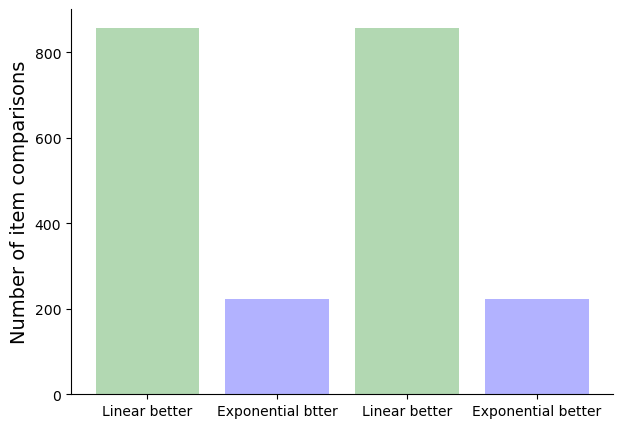

In [9]:
plt.figure(figsize=(7,5))
ax = plt.subplot(111)
plt.bar([1, 3], [itemwise_aic_lin_better, itemwise_bic_lin_better], color='g', alpha=0.3)
plt.bar([2, 4], [itemwise_aic_exp_better, itemwise_bic_exp_better], color='b', alpha=0.3)
plt.xticks(np.arange(1, 5), ['Linear better', 'Exponential btter', 'Linear better', 'Exponential better'])
plt.ylabel('Number of item comparisons', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'AIC_BIC_PHQ9.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

## Get linear slopes for every patient's item response trajectories
This cell directly extracts the linear slopes for each questionnaire.

In [10]:
# Initialize the slopes dataframes to store fitted slopes
df_slopes = pd.DataFrame(columns=['id', 'item', 'slope_lin'])
df_idx = 0
for patient_idx, patient_id in enumerate(valid_phq_subjects):
    d_patient = d_phq[d_phq['ID']==patient_id]
    # PHQ fits
    for item_number in np.arange(1, 10): 
        xs, ys = get_indiv_item_curve(d_patient, item_number, questionnaire='phq')
        init_slope = (ys[-1] - ys[0]) / (xs[-1] - xs[0])
        init_intercept = ys[0]
        res = minimize(rss_linear, x0=[init_slope, init_intercept], args=(np.array(xs), np.array(ys)))
        slope, intercept = res.x
        df_slopes.loc[df_idx] = [patient_id, item_number, slope]
        df_idx += 1

## PHQ-9:  Plot average slopes across patients for each item

         Source         W  ddof1          Q     p-unc
Friedman   item  0.020491      8  19.671193  0.011654
0.001388888888888889
Items 2 and 4 are significantly different
p = 0.001058
effect = -0.452450
Items 4 and 2 are significantly different
p = 0.001058
effect = 0.452450


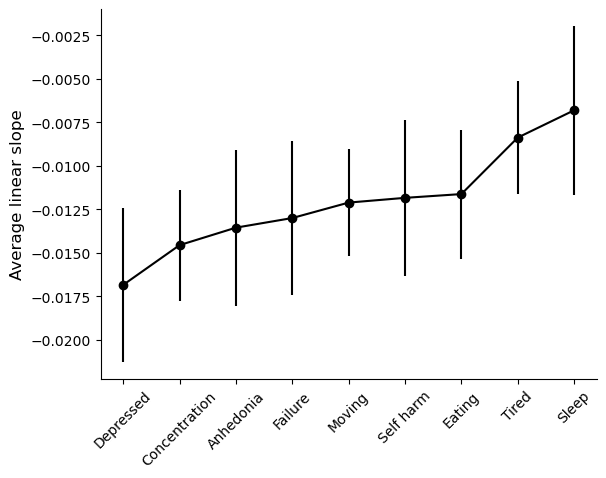

In [11]:
phq_items = ['Anhedonia', 'Depressed', 'Sleep', 'Tired', 'Eating', 'Failure', 'Concentration', 'Moving', 'Self harm']
plt.figure()
ax = plt.subplot(111)
all_slopes = []
avg_slopes = []
sem_slopes = []
for item_number in np.arange(1, 10):
    item_slopes = df_slopes[df_slopes['item']==item_number]['slope_lin']
    all_slopes.append(item_slopes.values)
    avg_slopes.append(item_slopes.mean())
    ci95 = 1.96 * np.std(item_slopes) / math.sqrt(item_slopes.shape[0])
    sem_slopes.append(stats.sem(item_slopes))
tuples = list(zip(phq_items, avg_slopes, sem_slopes))
tuples.sort(key = lambda x: x[1])
sorted_item_names = [t[0] for t in tuples]
ys = [t[1] for t in tuples]
yerrs = [t[2] for t in tuples]
ax.errorbar(np.arange(1, 10), ys, yerr=yerrs, marker='o', color='k')
plt.xticks(np.arange(1, 10), sorted_item_names, rotation=45)
plt.ylabel('Average linear slope', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'avgSlopesPHQ9.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

# Friedman test for repeated measures
print(pg.friedman(data=df_slopes, dv="slope_lin", within="item", subject="id"))

# Post hoc tests
num_comparisons = 9 * 8 / 2  # k(k-1)/2
bonferroni = 0.05 / num_comparisons
print(bonferroni)
for i in np.arange(1, 10):
    for j in np.arange(1, 10):
        if i == j:
            continue
        slopes_i = df_slopes[df_slopes['item']==i]['slope_lin'].values
        slopes_j = df_slopes[df_slopes['item']==j]['slope_lin'].values
        stat, p = stats.wilcoxon(slopes_i, slopes_j)
        effect = (np.median(slopes_i) - np.median(slopes_j)) / np.mean([stats.iqr(slopes_i), stats.iqr(slopes_j)])
        if p < bonferroni:
            print("Items %d and %d are significantly different" % (i, j))
            print("p = %f" % p)
            print("effect = %f" % effect)
            

## PCA in nine-dimensional space of PHQ-9 slopes

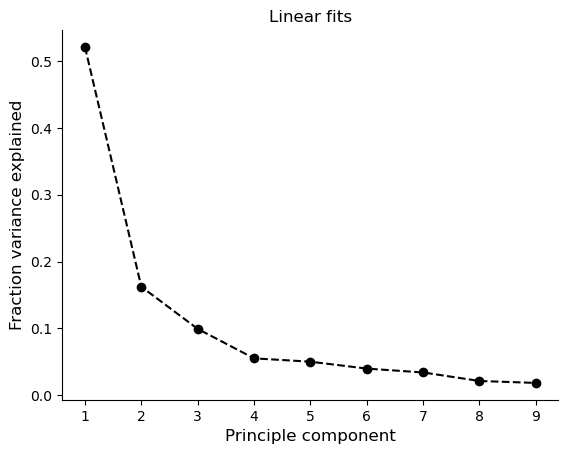

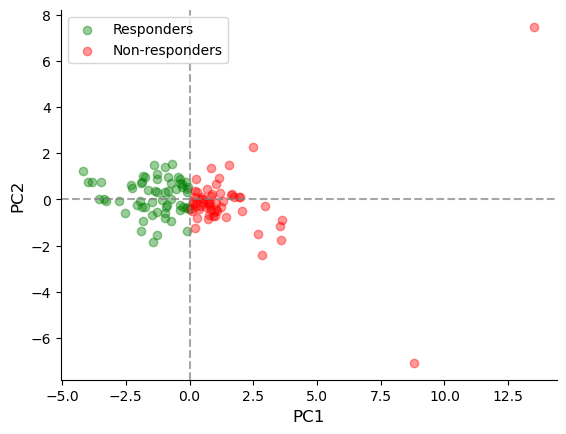

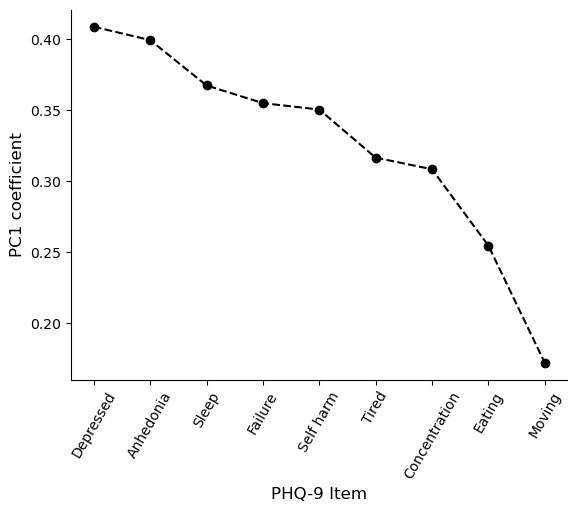

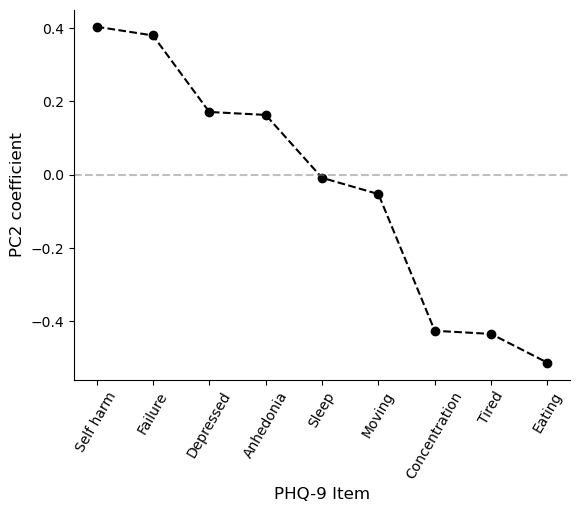

In [12]:
pca = PCA(n_components=9)

# Create an n x m matrix, where n is number of items, and m is number of patients
all_item_slopes = []
for item_num in np.arange(1, 10):
    # Slopes for each patient
    this_item_data = df_slopes[(df_slopes['item']==item_num)]
    item_slopes = this_item_data['slope_lin'].values
    item_sids = this_item_data['id'].values
    for i, sid in enumerate(item_sids):
        assert(sid == valid_phq_subjects[i])
    all_item_slopes.append(item_slopes) 
X = np.array(all_item_slopes).T

# Scale data by mean prior to computing PCA
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
pca.fit(X)
proj = pca.transform(X)

# Separate colormap
colors = []
for proj1 in proj[:, 0]:
    if proj1 < 0:
        colors.append('g')
    else:
        colors.append('r')

proj_responders = []
proj_nonresponders = []
for i in range(proj.shape[0]):
    proj1 = proj[i, 0]
    proj2 = proj[i, 1]
    if proj1 < 0:
        proj_responders.append([proj1, proj2])
    else:
        proj_nonresponders.append([proj1, proj2]) 
proj_responders = np.array(proj_responders)
proj_nonresponders = np.array(proj_nonresponders)

# Scree plot
varexp = pca.explained_variance_ratio_
plt.figure()
ax = plt.subplot(111)
plt.plot(np.arange(1, 10), varexp, linestyle='--', marker='o', color='k')
plt.title('Linear fits')
plt.xlabel('Principle component', fontsize=12)
plt.ylabel('Fraction variance explained', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'screePHQ9.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

# Projection into first 2 PCs
plt.figure()
ax = plt.subplot(111)
plt.scatter(proj_responders[:, 0], proj_responders[:, 1], marker='o', color = 'g', alpha=0.4, label='Responders')
plt.scatter(proj_nonresponders[:, 0], proj_nonresponders[:, 1], marker='o', color = 'r', alpha=0.4, label='Non-responders')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
# plt.xlim([-5.5, 5])
# plt.ylim([-3, 3])
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(loc='upper left')
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
plt.savefig(fname=outdir+'pcaProjPHQ9.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

# Coefficients for each item of the PCs
tuples = list(zip(phq_items, pca.components_[0, :], pca.components_[1, :]))

# PC1 coefficients
tuples.sort(key = lambda x: x[1], reverse=True)
sorted_item_names = [t[0] for t in tuples]
coefs = [t[1] for t in tuples]
plt.figure()
ax = plt.subplot(111)
plt.plot(range(len(coefs)), coefs, marker='o', linestyle='--', color='k')
plt.ylabel('PC1 coefficient', fontsize=12)
plt.xlabel('PHQ-9 Item', fontsize=12)
plt.xticks(range(len(coefs)), sorted_item_names, rotation=60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'pc1CoefPHQ9.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

# PC2 coefficients
tuples = list(zip(phq_items, pca.components_[0, :], pca.components_[1, :]))
tuples.sort(key = lambda x: x[2], reverse=True)
sorted_item_names = [t[0] for t in tuples]
coefs = [t[2] for t in tuples]
plt.figure()
ax = plt.subplot(111)
plt.plot(range(len(coefs)), coefs, marker='o', linestyle='--', color='k')
plt.ylabel('PC2 coefficient', fontsize=12)
plt.xlabel('PHQ-9 Item', fontsize=12)
plt.xticks(range(len(coefs)), sorted_item_names, rotation=60)
ax.axhline(y=0, linestyle='--', color='grey', alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'pc2CoefPHQ9.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

## PHQ: Which PCs are significant via parallel method
Run the appropriate PCA (slopes, drops/raises, etc) before running this.

In [13]:
# Evaluate significance of PCs by comparing to distribution of randomly generated data
n = 10000
percentile = 0.95
all_eigs = []
slope_min = df_slopes['slope_lin'].min()
slope_max = df_slopes['slope_lin'].max()
for i in range(n):
    rand = np.random.choice(np.random.uniform([slope_min, slope_max]), X.shape) # random item response matrix
    scaler = preprocessing.StandardScaler().fit(rand)
    rand_scaled = scaler.transform(rand)
    pca_rand = PCA(n_components=9).fit(rand_scaled)
    all_eigs.append(pca_rand.explained_variance_) # explained_variance field are the eigenvalues
all_eigs = np.array(all_eigs)
all_eigs.sort(axis=0)

print("\n95th percentile of randomly generated eigenvalues:")
print(all_eigs[int(percentile * n), :]) # print the 95th percentile eigenvalue for each column
print('\n')
print("Actual eigenvalues of the data:")
print(pca.explained_variance_)


95th percentile of randomly generated eigenvalues:
[1.59294853 1.39281445 1.25986973 1.14877449 1.05252553 0.96680008
 0.88350978 0.80023523 0.70452304]


Actual eigenvalues of the data:
[4.73370221 1.47235482 0.89912578 0.49821068 0.45268818 0.3589242
 0.30626898 0.19038135 0.16397404]


## Responders vs Non-responders: Average PHQ-9 sum score trajectories
Here responder is defined as negative coefficient of first PC.

62 responders, 58 non-responders
49 of 62 responders have complete sum score data
33 of 58 non-responders have complete sum score data

---Responder ANOVA---
          Source           SS   DF          MS          F         p-unc  \
0  sessionNumber  2747.755102    7  392.536443  46.708272  5.098293e-46   
1          Error  2823.744898  336    8.404003        NaN           NaN   

       np2       eps  
0  0.49318  0.808205  
1      NaN       NaN  

---Non-responder ANOVA---
          Source           SS   DF         MS         F     p-unc  p-GG-corr  \
0  sessionNumber   104.545455    7  14.935065  2.073152  0.047455   0.072569   
1          Error  1613.704545  224   7.204038       NaN       NaN        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.060844  0.703522      False  0.161293  0.001754  
1       NaN       NaN        NaN       NaN       NaN  

Responders: Mean change from baseline to final session: -8.714286 (CI95: -9.815164 to -7.613407)
Non-responders: 

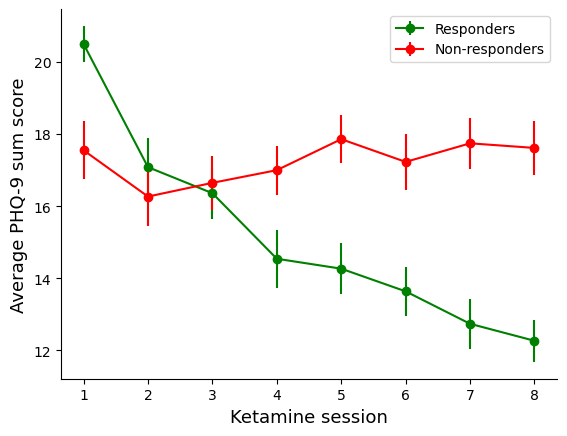

In [14]:
# PHQ-9 data
firstPC = proj[:, 0]
responder_idx = np.where(firstPC < 0)[0]
nonresponder_idx = np.where(firstPC >= 0)[0]
# SIDs
subjects = np.array(valid_phq_subjects)
responder_sids = subjects[responder_idx]
nonresponder_sids = subjects[nonresponder_idx]
print('%d responders, %d non-responders' % (len(responder_sids), len(nonresponder_sids)))

# Data
responder_data = d_phq[d_phq['ID'].isin(responder_sids)]
nonresponder_data = d_phq[d_phq['ID'].isin(nonresponder_sids)]

# Plot average PHQ-9 total scores across participants at the first 8 sessions
mus_r = []
mus_nr = []
sems_r = []
sems_nr = []
for sessionIdx in np.arange(1, 9):
    # Responders
    d_session = responder_data[responder_data['sessionNumber']==sessionIdx]
    mus_r.append(d_session['phqtotal'].mean())
    sems_r.append(d_session['phqtotal'].sem())
    # Nonresponders
    d_session = nonresponder_data[nonresponder_data['sessionNumber']==sessionIdx]
    mus_nr.append(d_session['phqtotal'].mean())
    sems_nr.append(d_session['phqtotal'].sem())
plt.figure()
ax = plt.subplot(111)
ax.errorbar(np.arange(1, 9), mus_r, yerr=sems_r, color='g', marker='o', linestyle='-', label='Responders')
ax.errorbar(np.arange(1, 9), mus_nr, yerr=sems_nr, color='r', marker='o', linestyle='-', label='Non-responders')
plt.xlabel('Ketamine session', fontsize=13)
plt.ylabel('Average PHQ-9 sum score', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend()
plt.savefig(fname=outdir+'sumScoresByResponder.pdf', format='pdf', dpi=resolution, bbox_inches="tight")


# RM ANOVAs for change in responders and non-responders
d_full = pd.DataFrame(columns=['ID', 'group', 'sessionNumber', 'phqtotal'])
ix = 0
for sid in unique_patient_ids:
    d_subject = d_phq[d_phq['ID']==sid]
    if sid in responder_sids:
        group = 'responder'
    elif sid in nonresponder_sids:
        group = 'nonresponder'
    else:
        print('Undefined patient')
        continue
    sessions = np.sort(d_subject['sessionNumber'].values)
    induction_sessions = [s for s in sessions if s <= 8]
    if len(induction_sessions) == 8:  # subjects with exactly 8 repeats of PHQ-9 total score
        for sessionNum in np.arange(1, 9):
            sumscore = d_subject[d_subject['sessionNumber']==sessionNum]['phqtotal'].values[0]
            d_full.loc[ix] = [sid, group, sessionNum, sumscore]
            ix += 1
            
dfull_responders = d_full[d_full['group']=='responder']  
dfull_nonresponders = d_full[d_full['group']=='nonresponder']  
sid_full_responder = dfull_responders['ID'].unique()
sid_full_nonresponder = dfull_nonresponders['ID'].unique()

print("%d of %d responders have complete sum score data" % (len(sid_full_responder), len(responder_sids)))
print("%d of %d non-responders have complete sum score data" % (len(sid_full_nonresponder), len(nonresponder_sids)))

print("\n---Responder ANOVA---")
aov = pg.rm_anova(dv='phqtotal', within='sessionNumber', subject='ID',
                  data=dfull_responders, detailed=True, effsize="np2")
print(aov)

print("\n---Non-responder ANOVA---")
aov = pg.rm_anova(dv='phqtotal', within='sessionNumber', subject='ID',
                  data=dfull_nonresponders, detailed=True, effsize="np2")
print(aov)


# Compute mean changes from baseline to final session for the responders and non-responders
deltas_responders = []
deltas_nonresponders = []
for sid in sid_full_responder:
    d = d_full[d_full['group']=='responder']
    baseline = d[(d['ID']==sid) & (d['sessionNumber']==1)]['phqtotal'].values[0]
    final = d[(d['ID']==sid) & (d['sessionNumber']==8)]['phqtotal'].values[0]
    deltas_responders.append(final - baseline)
for sid in sid_full_nonresponder:
    d = d_full[d_full['group']=='nonresponder']
    baseline = d[(d['ID']==sid) & (d['sessionNumber']==1)]['phqtotal'].values[0]
    final = d[(d['ID']==sid) & (d['sessionNumber']==8)]['phqtotal'].values[0]
    deltas_nonresponders.append(final - baseline)
mu_r = np.mean(deltas_responders)
ci95_r = 1.96 * stats.sem(deltas_responders)
mu_nr = np.mean(deltas_nonresponders)
ci95_nr = 1.96 * stats.sem(deltas_nonresponders)
print("\nResponders: Mean change from baseline to final session: %f (CI95: %f to %f)" % 
      (mu_r, mu_r - ci95_r, mu_r + ci95_r))
print("Non-responders: Mean change from baseline to final session: %f (CI95: %f to %f)" % 
      (mu_nr, mu_nr - ci95_nr, mu_nr + ci95_nr))

## PC2 Affective vs. Somatic: Sum-score trajectories

62 responders, 58 non-responders
27 affective-dominant responders, 35 somatic-dominant responders
22 of 27 affective-dominant responders have complete data
27 of 35 somatic-dominant responders have complete data

---Affective cluster ANOVA---
          Source          SS  DF1  DF2          MS          F         p-unc  \
0          group   37.984763    1   47   37.984763   1.065572  3.072305e-01   
1  sessionNumber  766.854592    7  329  109.550656  41.934245  4.567482e-42   
2    Interaction   18.527984    7  329    2.646855   1.013174  4.216323e-01   

      p-GG-corr       np2      eps sphericity   W-spher  p-spher  
0           NaN  0.022169      NaN        NaN       NaN      NaN  
1  1.062820e-35  0.471520  0.83411       True  0.508874  0.28524  
2           NaN  0.021102      NaN        NaN       NaN      NaN  

---Somatic cluster ANOVA---
          Source          SS  DF1  DF2          MS          F         p-unc  \
0          group  119.863984    1   47  119.863984   1.941463  1

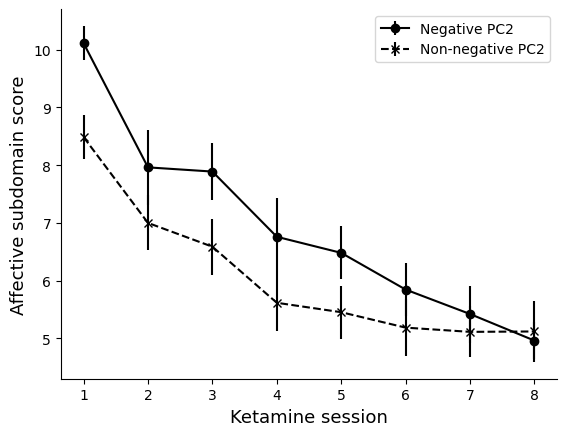

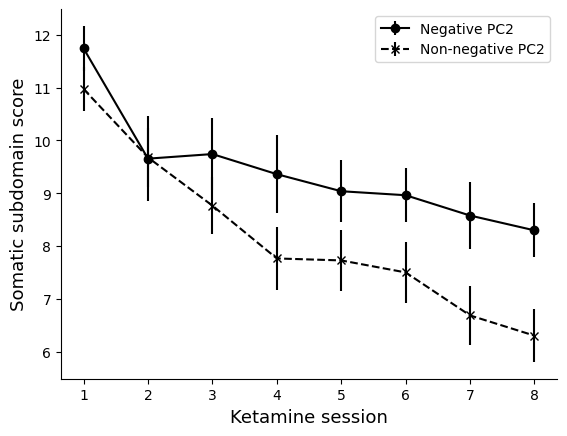

In [15]:
def affectiveSums(df):
    affective_items = ['phqitem' + str(i) for i in [1, 2, 6, 9]]
    all_sums = []
    for index, row in df.iterrows():
        item_vals = row[affective_items].values
        all_sums.append(sum(item_vals))
    return all_sums
    

def somaticSums(df):
    somatic_items = ['phqitem' + str(i) for i in [3, 4, 5, 7, 8]]
    all_sums = []
    for index, row in df.iterrows():
        item_vals = row[somatic_items].values
        all_sums.append(sum(item_vals))
    return all_sums


# PHQ-9 data
firstPC = proj[:, 0]
responder_idx = np.where(firstPC < 0)[0]
nonresponder_idx = np.where(firstPC >= 0)[0]

secondPC = proj[:, 1]
affective_idx = np.where(secondPC < 0)[0]
somatic_idx = np.where(secondPC >= 0)[0]


# SIDs
subjects = np.array(valid_phq_subjects)
responder_sids = subjects[responder_idx]
nonresponder_sids = subjects[nonresponder_idx]
affective_sids = subjects[affective_idx]
somatic_sids = subjects[somatic_idx]
r_affective_sids = list(set(responder_sids).intersection(affective_sids))
r_somatic_sids = list(set(responder_sids).intersection(somatic_sids))

print('%d responders, %d non-responders' % (len(responder_sids), len(nonresponder_sids)))
print('%d affective-dominant responders, %d somatic-dominant responders' % 
      (len(r_affective_sids), len(r_somatic_sids)))


# Responder data (somatic and affetive break-outs)
r_affective = d_phq[d_phq['ID'].isin(r_affective_sids)]
r_somatic = d_phq[d_phq['ID'].isin(r_somatic_sids)]


# -- Responders Only -- 
# Plot trajectories of sub-sum-scores for affetive and somatic symptom clusters
# separately broken out by responder-affetive and responder-somatic groups

mus_AR_affective = []
mus_SR_affective = []
mus_AR_somatic = []
mus_SR_somatic = []
sems_AR_affective = []
sems_SR_affective = []
sems_AR_somatic = []
sems_SR_somatic = []
for sessionIdx in np.arange(1, 9):
    # Get data for this session, split by affective- and somatic-dominant response
    d_AR = r_affective[r_affective['sessionNumber']==sessionIdx]
    d_SR = r_somatic[r_somatic['sessionNumber']==sessionIdx]
    
    # Affective dominant responders: split by affective and somatic symptom clusters
    # --> Affective cluster response
    affectiveSumScores = affectiveSums(d_AR)
    mus_AR_affective.append(np.mean(affectiveSumScores))
    sems_AR_affective.append(stats.sem(affectiveSumScores))
    # --> Somatic cluster response
    somaticSumScores = somaticSums(d_AR)
    mus_AR_somatic.append(np.mean(somaticSumScores))
    sems_AR_somatic.append(stats.sem(somaticSumScores))
    
    # Somatic dominant responders: split by affective and somatic symptom clusters
    # --> Affective cluster response
    affectiveSumScores = affectiveSums(d_SR)
    mus_SR_affective.append(np.mean(affectiveSumScores))
    sems_SR_affective.append(stats.sem(affectiveSumScores))
    # --> Somatic cluster response
    somaticSumScores = somaticSums(d_SR)
    mus_SR_somatic.append(np.mean(somaticSumScores))
    sems_SR_somatic.append(stats.sem(somaticSumScores))
    
    
plt.figure()
ax = plt.subplot(111)
ax.errorbar(np.arange(1, 9), mus_AR_affective, yerr=sems_AR_affective, color='k', marker='o', linestyle='-', label='Negative PC2')
ax.errorbar(np.arange(1, 9), mus_SR_affective, yerr=sems_SR_affective, color='k', marker='x', linestyle='--', label='Non-negative PC2')
plt.xlabel('Ketamine session', fontsize=13)
plt.ylabel('Affective subdomain score', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend()
plt.savefig(fname=outdir+'affectiveClusterSumScores.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

plt.figure()
ax = plt.subplot(111)
ax.errorbar(np.arange(1, 9), mus_AR_somatic, yerr=sems_AR_somatic, color='k', marker='o', linestyle='-', label='Negative PC2')
ax.errorbar(np.arange(1, 9), mus_SR_somatic, yerr=sems_SR_somatic, color='k', marker='x', linestyle='--', label='Non-negative PC2')
plt.xlabel('Ketamine session', fontsize=13)
plt.ylabel('Somatic subdomain score', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend()
plt.savefig(fname=outdir+'somaticClusterSumScores.pdf', format='pdf', dpi=resolution, bbox_inches="tight")


# RM ANOVAs
d_full = pd.DataFrame(columns=['ID', 'group', 'sessionNumber', 'affective_total', 'somatic_total'])
ix = 0
for sid in unique_patient_ids:
    d_subject = d_phq[d_phq['ID']==sid]
    if sid in r_affective_sids:
        group = 'AR'
    elif sid in r_somatic_sids:
        group = 'SR'
    else:
        group = 'NA'
        continue
    sessions = np.sort(d_subject['sessionNumber'].values)
    induction_sessions = [s for s in sessions if s <= 8]
    if len(induction_sessions) == 8:  # subjects with exactly 8 repeats of PHQ-9 total score
        for sessionNum in np.arange(1, 9):
            d_session = d_subject[d_subject['sessionNumber']==sessionNum]
            affective_score = affectiveSums(d_session)
            somatic_score = somaticSums(d_session)    
            d_full.loc[ix] = [sid, group, sessionNum, affective_score[0], somatic_score[0]]
            ix += 1
            
dfull_AR = d_full[d_full['group']=='AR']  
dfull_SR = d_full[d_full['group']=='SR']  
sid_full_AR = dfull_AR['ID'].unique()
sid_full_SR = dfull_SR['ID'].unique()

print("%d of %d affective-dominant responders have complete data" % (len(sid_full_AR), len(r_affective_sids)))
print("%d of %d somatic-dominant responders have complete data" % (len(sid_full_SR), len(r_somatic_sids)))

print("\n---Affective cluster ANOVA---")
aov = pg.mixed_anova(dv='affective_total', within='sessionNumber', 
                     between='group', subject='ID', correction=True, data=d_full)
print(aov)

print("\n---Somatic cluster ANOVA---")
aov = pg.mixed_anova(dv='somatic_total', within='sessionNumber', between='group', subject='ID', data=d_full)
print(aov)

## Compute classical percent change in sum score (from baseline to last session) for responders and non-responders
Responders and non-responders are defined, as above, by the sign of PC1

responder avg (SEM) change: 0.417711 +/- 0.024949
non-responder avg (SEM) change: -0.188089 +/- 0.112140
responder median (IQR) change: 0.384921 +/- 0.253007
non-responder median (IQR) change: 0.000000 +/- 0.223162


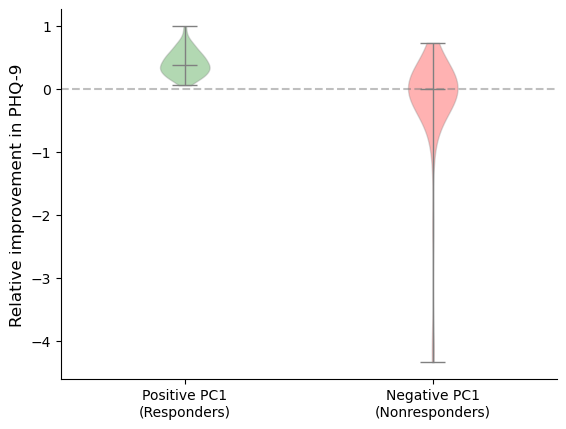

In [16]:
df_relative_sum = pd.DataFrame(columns=['id', 'rel_change'])
df_idx = 0
# PHQ-9
for patient_idx, patient_id in enumerate(valid_phq_subjects):
    d_patient = d_phq[d_phq['ID']==patient_id]
    xs, ys = get_indiv_sum_curve(d_patient, questionnaire='phq')
    rel_change = (ys[0] - ys[-1]) / ys[0]
    df_relative_sum.loc[df_idx] = [patient_id, rel_change]
    df_idx += 1

# Evaluate the classical percent change for responders and non-responders 
r_change = df_relative_sum[df_relative_sum['id'].isin(responder_sids)]['rel_change'].values
nr_change = df_relative_sum[df_relative_sum['id'].isin(nonresponder_sids)]['rel_change'].values
print('responder avg (SEM) change: %f +/- %f' % (np.mean(r_change), stats.sem(r_change)))
print('non-responder avg (SEM) change: %f +/- %f' % (np.mean(nr_change), stats.sem(nr_change)))

print('responder median (IQR) change: %f +/- %f' % (np.median(r_change), stats.iqr(r_change)))
print('non-responder median (IQR) change: %f +/- %f' % (np.median(nr_change), stats.iqr(nr_change)))

plt.figure()
ax = plt.subplot(111)
ax.axhline(y=0, linestyle='--', color='grey', alpha=0.5)
vp = ax.violinplot([r_change, nr_change], positions=[1,2], showmeans=False, showmedians=True,
                   widths=0.2)
plt.xlim([0.5, 2.5])
plt.xticks([1, 2], ['Positive PC1\n(Responders)', 'Negative PC1\n(Nonresponders)'])
plt.ylabel('Relative improvement in PHQ-9', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

parts = vp["bodies"]
colors=['green', 'red']
for i in range(len(parts)):
    parts[i].set_facecolor(colors[i])
    parts[i].set_edgecolor('grey')
    parts[i].set_edgecolor('grey')
for partname in ('cbars','cmins','cmaxes','cmedians'):
    part = vp[partname]
    part.set_edgecolor('grey')
    part.set_linewidth(1)
plt.savefig(fname=outdir+'relativeImprovementByPC1.pdf', format='pdf', dpi=resolution, bbox_inches="tight")


## Logistic regression (with exhaustive feature selection) to predict response from baseline symtpoms
Evaluate all 511 possible combinations of items as features, cross validating each.

In [14]:
# Generate list of all combinations of items to use as features
all_combos = []
for r in np.arange(1, 10):
    combos = combinations(all_phq_item_cols, r)
    for c in combos:
        c = list(c)
        all_combos.append(c)
n_combos = len(all_combos)
        
# Baseline PHQ-9 for PHQ-9 responders and non-responders
baseline_data = d_phq[d_phq['sessionNumber']==1].sort_values(by='ID')
    
# Loop over all feature sets, cross validating the prediction performance of each
df_cv_all = pd.DataFrame(columns=['features', 'coefs', 'all_accuracy', 'accuracy_mean', 'accuracy_ci',
                                  'precision', 'recall', 'f1'])
idx = 0
for i, c in enumerate(all_combos):
    if i % 5 == 0:
        print('processing model %d of %d' % (i, n_combos))
    x = baseline_data[c].values
    y = np.array([1 if p < 0 else 0 for p in proj[:, 0]])
    # Fit model to raw data to get coefs
    model = LogisticRegression().fit(x, y)
    coefs = model.coef_[0]
    # Cross validate to get model performance for this feature set
    rkf = RepeatedKFold(n_splits=5, n_repeats=1000)
    all_acc = []
    all_conf = np.zeros((2,2))
    for train, test in rkf.split(x):
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model = LogisticRegression().fit(x_train, y_train)
        all_acc.append(model.score(x_test, y_test))
        y_pred = model.predict(x_test)
        all_conf += confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0, 1])
    ci95 = 1.95 * np.std(all_acc) / math.sqrt(len(all_acc))
    precision = all_conf[1][1] / (all_conf[1][1] + all_conf[0][1])
    recall = all_conf[1][1] / (all_conf[1][1] + all_conf[1][0])
    f1 = 2 * (precision * recall) / (precision + recall)
    df_cv_all.loc[idx] = [c, list(coefs), all_acc, np.mean(all_acc), ci95, precision, recall, f1]
    idx += 1
    
    if i > 1:
        break
    
# Save the tuning results to disk
headers = ['features', 'coefs', 'all_accuracy', 'accuracy_mean', 'accuracy_ci', 'precision', 'recall', 'f1']
with open(preprocess_outdir + 'cvFeatureSelection.csv', 'wb') as outFile:
    df_cv_all.to_csv(outFile, header=headers, index=False)

processing model 0 of 511
processing model 5 of 511
processing model 10 of 511


## Read exhaustive feature selection dataframe from disk

In [17]:
def convertFeatures(f, sep=', ', toNum=False):
    f = f.strip("[]").split(sep)
    if toNum:
        f = [float(fi.strip("\'")) for fi in f]
    else:
        f = [fi.strip("\'") for fi in f]
    return f
df_cv_all = pd.read_csv(preprocess_outdir + 'cvFeatureSelection.csv')
df_cv_all['features'] = df_cv_all['features'].apply(convertFeatures, toNum=False)
df_cv_all['coefs'] = df_cv_all['coefs'].apply(convertFeatures, toNum=True)
df_cv_all['all_accuracy'] = df_cv_all['all_accuracy'].apply(convertFeatures, toNum=True)

## Examine the best model from exhaustive feature selection

In [17]:
# Evaluate the model performances
df_sorted = df_cv_all.sort_values(by='accuracy_mean', ascending=False)
all_accs = df_sorted['accuracy_mean'].values
plt.figure()
ax = plt.subplot(111)
plt.hist(df_sorted['accuracy_mean'].values, color='w', edgecolor='k')
plt.xlabel('CV classification accuracy', fontsize=12)
plt.ylabel('Number of models', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'histAllModelMeanAcc.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

# How many are beter than chance?
num_good = df_sorted[df_sorted['accuracy_mean'] > 0.5].shape[0]
num_overall = df_sorted.shape[0]
print("%d / %d (%f) models had better than chance CV classifiation accuracy" % 
     (num_good, num_overall, num_good/num_overall))

# Evaluate the "best" model
best_model = df_sorted.iloc[0]
print("----Model with best CV accuracy---")
print(best_model)
plt.figure()
ax = plt.subplot(111)
plt.hist(best_model['all_accuracy'], color='w', edgecolor='k', bins=np.arange(0.3, 1.0, 0.05))
plt.xlabel('CV classification accuracy', fontsize=12)
plt.ylabel('Number of CV iterations', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom') 
plt.savefig(fname=outdir+'histBestModelCVAcc.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

NameError: name 'df_cv_all' is not defined

## Analyze average baseline item responses between responders and non-responders
Attempt to better understand the nature of differences that allow for prediction.


PHQ for PHQ response p-values
[0.01180287 0.00259783 0.00719316 0.01729472 0.01345837 0.07416419
 0.04275155 0.27706358 0.35987147]


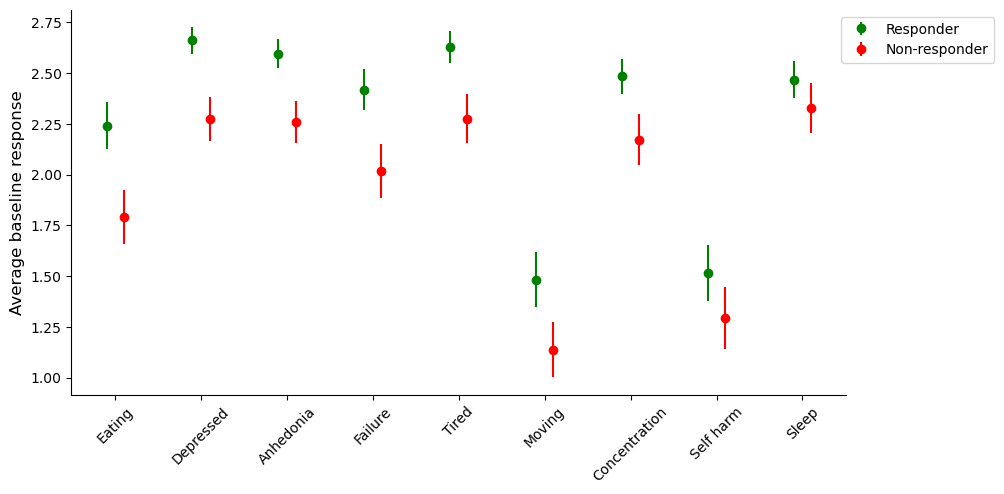

In [18]:
# Baseline PHQ-9 for PHQ-9 responders and non-responders
baseline_data = d_phq[(d_phq['sessionNumber']==1)]
for i, sid in enumerate (baseline_data['ID'].values):
    assert(sid == valid_phq_subjects[i])

x = baseline_data[all_phq_item_cols].values
y = np.array([1 if p < 0 else 0 for p in proj[:, 0]])
improved_idx = np.where(y == 1)[0]
worsened_idx = np.where(y == 0)[0]
df_baseline = pd.DataFrame(columns=['item_name', 'improved_means', 'improved_sems',
                                    'worsened_means', 'worsened_sems',
                                    'effect_size', 'p_value'])
idx = 0
for i, item in enumerate(phq_items):
    baseline_item_vals = x[:, i]
    improved_means = np.mean(baseline_item_vals[improved_idx])
    worsened_means = np.mean(baseline_item_vals[worsened_idx])
    improved_sems = stats.sem(baseline_item_vals[improved_idx])
    worsened_sems = stats.sem(baseline_item_vals[worsened_idx])
    g = pg.compute_effsize(baseline_item_vals[improved_idx],
                                     baseline_item_vals[worsened_idx], eftype='CLES')
    t, p = stats.ttest_ind(baseline_item_vals[improved_idx],
                              baseline_item_vals[worsened_idx])
    df_baseline.loc[idx] = [item, improved_means, improved_sems, worsened_means, worsened_sems, np.abs(g), p]
    idx += 1
df_baseline = df_baseline.sort_values(by='effect_size', ascending=False)
print("\nPHQ for PHQ response p-values")
print(df_baseline['p_value'].values)
    
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
xs1 = np.arange(len(phq_items))
ax.errorbar(xs1, df_baseline['improved_means'], yerr=df_baseline['improved_sems'], linestyle='None', color='g', marker='o', label='Responder')
ax.errorbar(xs1+0.2, df_baseline['worsened_means'], yerr=df_baseline['worsened_sems'], linestyle='None', color='r', marker='o', label='Non-responder')
plt.xticks(xs1+0.1, df_baseline['item_name'], rotation=45)
plt.ylabel('Average baseline response', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(bbox_to_anchor=(0, 0., 1.2, 1))
plt.savefig(fname=outdir+'baselineItemsByResponder.pdf', format='pdf', dpi=resolution, bbox_inches="tight")



# dpred_full = pd.DataFrame(columns=['id', 'responded', 'item', 'itemval'])
# ix = 0
# for i, sid in enumerate(d_phq['ID'].unique()):
#     if i in improved_idx:
#         responded = 1
#     else:
#         responded = 0
#     for item in all_phq_item_cols:
#         item_val = d_phq[(d_phq['ID']==sid) & (d_phq['sessionNumber']==1)][item].values[0]
#         dpred_full.loc[ix] = [sid, responded, item, item_val]
#         ix += 1

# aov = pg.mixed_anova(dv='itemval', between='responded', within='item', subject='id', data=dpred_full)
# print(aov.round(3))

# aov = pg.pairwise_tests(data=dpred_full, dv='itemval', between='responded', within='item', subject='id')
# print(aov.round(3))



## Exhaustive feature selection with threshold tuning
Examine all 511 feature sets, as above, but now for each of these models try a full range of decision thresholds from prbability 0 to 1. Thus, we now are effectively evaluating thousands of models, cross validating each.

In [119]:
all_phq_item_cols = ['phqitem' + str(i) for i in np.arange(1, 10)]
baseline_data = d_phq[d_phq['sessionNumber']==1]
for i, sid in enumerate(baseline_data['ID'].values):
    assert(sid == valid_phq_subjects[i])
    
all_combos = []
for r in np.arange(1, 10):
    combos = combinations(all_phq_item_cols, r)
    for c in combos:
        c = list(c)
        all_combos.append(c)
n_combos = len(all_combos)

df = pd.DataFrame(columns=['features', 'sensitivity', 'specificity', 'ppv', 'npv', 'acc', 'thresh'])
ix = 0
y = np.array([1 if p < 0 else 0 for p in proj[:, 0]])
for i, c in enumerate(all_combos):
    if i % 10 == 0:
        print('processing model %d of %d' % (i, n_combos))
    x = baseline_data[c].values
    for decision_thresh in np.arange(0, 1, 0.05):
        rkf = RepeatedKFold(n_splits=5, n_repeats=200)
        conf = np.zeros((2,2))
        for train, test in rkf.split(x):
            x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
            model = LogisticRegression().fit(x_train, y_train)
            probclass = model.predict_proba(x_test)
            y_pred = []
            for i in range(probclass.shape[0]):
                prob0, prob1 = probclass[i, :]
                if prob1 > decision_thresh:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
            conf += confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0, 1])
        accuracy = (conf[0][0] + conf[1][1]) / np.sum(conf)
        PPV = conf[1][1] / (conf[1][1] + conf[0][1])
        NPV = conf[0][0] / (conf[0][0] + conf[1][0])
        sensitivity = conf[1][1] / (conf[1][1] + conf[1][0])
        specificity = conf[0][0] / (conf[0][0] + conf[0][1])
        df.loc[ix] = [c, sensitivity, specificity, PPV, NPV, accuracy, decision_thresh]
        ix += 1
        
        
 # Save the tuning results to disk
headers = ['features', 'sensitivity', 'specificity', 'ppv', 'npv', 'acc', 'thresh']
with open(preprocess_outdir + 'cvTuning.csv', 'wb') as outFile:
    df.to_csv(outFile, header=headers, index=False)

processing model 0 of 511
processing model 10 of 511
processing model 20 of 511
processing model 30 of 511
processing model 40 of 511
processing model 50 of 511
processing model 60 of 511
processing model 70 of 511
processing model 80 of 511
processing model 90 of 511
processing model 100 of 511
processing model 110 of 511
processing model 120 of 511
processing model 130 of 511
processing model 140 of 511
processing model 150 of 511
processing model 160 of 511
processing model 170 of 511
processing model 180 of 511
processing model 190 of 511
processing model 200 of 511
processing model 210 of 511
processing model 220 of 511
processing model 230 of 511
processing model 240 of 511
processing model 250 of 511
processing model 260 of 511
processing model 270 of 511
processing model 280 of 511
processing model 290 of 511
processing model 300 of 511
processing model 310 of 511
processing model 320 of 511
processing model 330 of 511
processing model 340 of 511
processing model 350 of 511
pro

## Read threshold tuning dataframe from disk

In [151]:
def convertFeatures(f):
    f = f.strip("[]").split(", ")
#     print(f[0])
    f = [fi.strip("\'") for fi in f]
    return f
df = pd.read_csv(preprocess_outdir + 'cvTuning.csv')
df['features'] = df['features'].apply(convertFeatures)

## For different predictive values (PPV/NPV, x-axis), plot the best coverage (Sensitivity/Specificity) out of all models with that predicive value

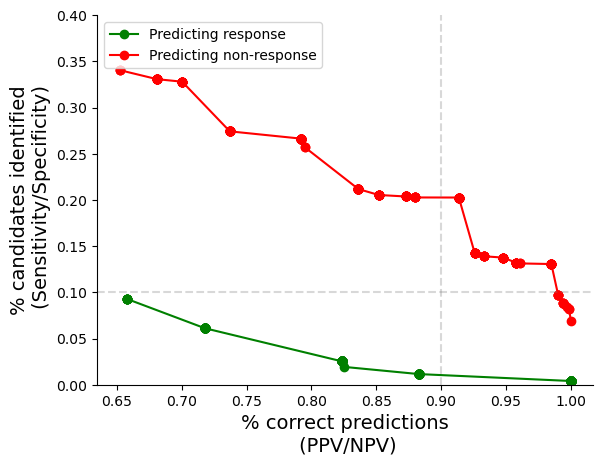

In [161]:
baseline_data = d_phq[d_phq['sessionNumber']==1]
y = np.array([1 if p < 0 else 0 for p in proj[:, 0]])

dfx = pd.DataFrame(columns=['type', 'target', 'ppv', 'npv', 'sensitivity', 'specificity'])
ix = 0
min_targets = np.arange(0.65, 1.0, 0.001)
for mt in min_targets:
    # Extract the top models from CV
    top_neg_model = df[df['npv']>=mt].sort_values(by='specificity', ascending=False).iloc[0]
    top_pos_model = df[df['ppv']>=mt].sort_values(by='sensitivity', ascending=False).iloc[0]
    custom_cols_neg = top_neg_model.features
    custom_cols_pos = top_pos_model.features
    thresh_neg = top_neg_model.thresh
    thresh_pos = top_pos_model.thresh
    
    # Negative model
    dfx.loc[ix] = ['neg', mt, top_neg_model.ppv, top_neg_model.npv,
                   top_neg_model.sensitivity, top_neg_model.specificity]
    ix += 1

    # Positive model
    dfx.loc[ix] = ['pos', mt, top_pos_model.ppv, top_pos_model.npv,
                   top_pos_model.sensitivity, top_pos_model.specificity]
    ix += 1
    
dfp = dfx[dfx['type']=='pos'].sort_values(by='target')
dfn = dfx[dfx['type']=='neg'].sort_values(by='target')
 
plt.figure()
ax = plt.subplot(111)
plt.plot(dfp['ppv'], dfp['sensitivity'], color='g', marker='o', label='Predicting response')
plt.plot(dfn['npv'], dfn['specificity'], color='r', marker='o', label='Predicting non-response')
ax.axvline(x=0.90, linestyle='--', color='grey', alpha=0.3)
ax.axhline(y=0.10, linestyle='--', color='grey', alpha=0.3)
plt.xlabel('% correct predictions\n (PPV/NPV)', fontsize=14)
plt.ylabel('% candidates identified\n (Sensitivity/Specificity)', fontsize=14)
plt.ylim([0, 0.4])
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'sens_vs_ppv_all.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

## Identify the best model for predicting non-response among those with NPV > 90% and specificity > 10%
Arithmetic mean of NPV and specificity

Predicting NON-response
PPV (CV): 0.568322
NPV (CV): 0.913686
Sensitivity (CV): 0.982097
Specificity (CV): 0.202586
Accuracy (CV): 0.605333


Top negative model
features       [phqitem2, phqitem5, phqitem9]
sensitivity                          0.982097
specificity                          0.202586
ppv                                  0.568322
npv                                  0.913686
acc                                  0.605333
thresh                                    0.3
score                                0.558136
Name: 1746, dtype: object


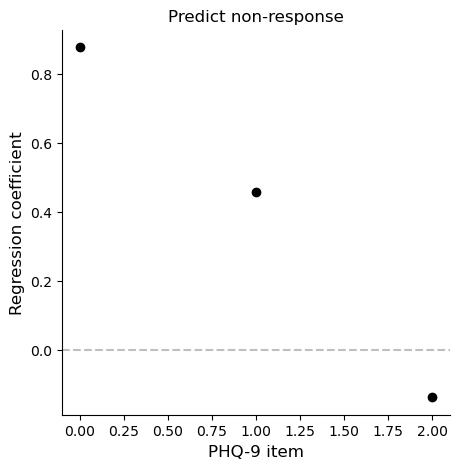

In [164]:
baseline_data = d_phq[d_phq['sessionNumber']==1]
y = np.array([1 if p < 0 else 0 for p in proj[:, 0]])

# Negative models
all_neg_models = df[(df['npv']>=0.9) & (df['specificity']>0.10)]
all_neg_models['score'] = 0.5 * all_neg_models['npv'] + 0.5 * all_neg_models['specificity']
top_neg_model = all_neg_models.sort_values(by='score', ascending=False).iloc[0]

cols = top_neg_model.features
x = baseline_data[cols].values
model = LogisticRegression(penalty='none').fit(x, y)
        
print("Predicting NON-response")
print("PPV (CV): %f" % top_neg_model.ppv)
print("NPV (CV): %f" % top_neg_model.npv)
print("Sensitivity (CV): %f" % top_neg_model.sensitivity)
print("Specificity (CV): %f" % top_neg_model.specificity)
print("Accuracy (CV): %f" % top_neg_model.acc)
print('\n')

raw_coefs = list(zip(cols, model.coef_[0]))
raw_coefs.sort(key=lambda x: x[1], reverse=True)
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.plot(np.arange(len(raw_coefs)), [c[1] for c in raw_coefs], linestyle='None', marker='o', color='k')
# plt.xticks(np.arange(len(raw_coefs)), ['Depressed Mood', 'Eating', 'Self-Harm'], rotation=50)
ax.axhline(y=0, linestyle='--', color='grey', alpha=0.5)
plt.title("Predict non-response", fontsize=12)
plt.xlabel('PHQ-9 item', fontsize=12)
plt.ylabel('Regression coefficient', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig(fname=outdir+'bestNegModelCoefs.pdf', format='pdf', dpi=resolution, bbox_inches="tight")

print("Top negative model")
print(top_neg_model)

## Distribution of parameters across all good models for predicting non-response
All the models meeting pre-specified performance criteria of > 90% NPV and > 10% specificity. Note that most models do not include all nine items as features; this is a distribution plot across all good models.

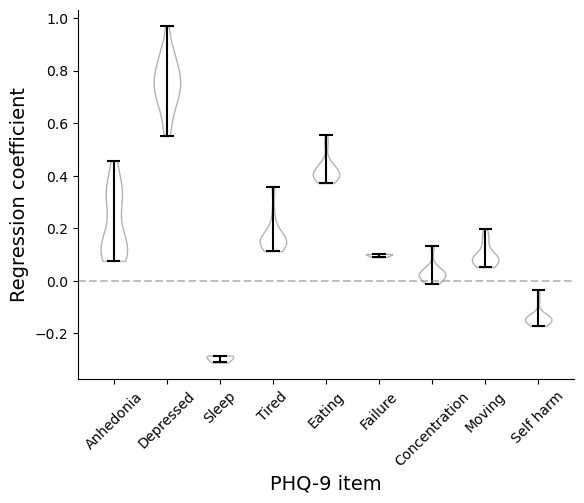

In [165]:
ms = all_neg_models.sort_values(by='score', ascending=False)
y = np.array([1 if p < 0 else 0 for p in proj[:, 0]])

params = [[] for i in range(9)]
for model_ix in range(ms.shape[0]):
    m = ms.iloc[model_ix]
    fs = m['features']
    x = baseline_data[fs].values
    model = LogisticRegression(penalty='none').fit(x, y)
    for feature_ix, f in enumerate(fs):
        param_val = model.coef_[0][feature_ix] 
        param_ix = int(f[-1]) - 1  # index from 0 - 8 of this param
        params[param_ix].append(param_val)

plt.figure()
ax = plt.subplot(111)
vp = plt.violinplot(params)
for pc in vp['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
for partname in ('cmaxes', 'cmins', 'cbars'):
    vp[partname].set_edgecolor('black')
ax.axhline(y=0, linestyle='--', color='grey', alpha=0.5)
plt.xticks(np.arange(1, 10), phq_items, rotation=45)
plt.xlabel('PHQ-9 item', fontsize=14)
plt.ylabel('Regression coefficient', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fname=outdir+'allNegModelCoefs.pdf', format='pdf', dpi=resolution, bbox_inches="tight")